# Příklad zpracování sktrukturovaných dat

Co se naučíme:
- Vyzkoušíme si predikci pravděpodobnosti pro reálná data.  
    - "S jakou pravděpodobnsotí má pacient onemocnění srdce?"
    - (Pravděpodobnost je buď v intervalu 0-1 nebo v procentech. Pravděpodobnsot 1 odpovídá 100%)
- Implementujeme třídy v pythonu
- Tentokrát použijeme knihovnu Lightning https://lightning.ai/docs/overview/getting-started
- Budeme měřit trénovací a validační chybu
    - Trénovací data model "viděl" během trénování
    - Validační data model nikdy neviděl


In [1]:
# Nainstalujeme chybějící knihovny (může trvat déle)
%pip install pandas==2.0.3
%pip install ipympl
%pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.0.3 which is incompatible.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 8.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cach

In [4]:
# Import potřebných knihoven ------------------------------------------------

# Knihovny pro zobrazování a interaktivitu
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
from ipywidgets import widgets, interact
import ipympl
from tqdm import tqdm
import prettytable as pt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython import display as IPydisplay

# Práce s daty
import urllib.request, json
import pandas as pd
import numpy as np

# Trénování
import torch
import lightning as L

# Můžeme se podívat na verze knihoven
print("Version of pandas: " + pd.__version__)
print("Version of prettytable: " + pt.__version__)
print("Version of numpy: " + np.__version__)
print("Version of torch: " + torch.__version__)
print("Version of lightning: " + L.__version__)

Version of pandas: 2.0.3
Version of prettytable: 3.11.0
Version of numpy: 1.26.4
Version of torch: 2.3.1+cu121
Version of lightning: 2.4.0


### Pomocné funkce

In [73]:
def print_data_sample(dataframe, patient_index):

    datarow = dataframe.iloc[patient_index]
    table = pt.PrettyTable()
    table.field_names = ["Feture Name", "Description", "Value for patient number " + str(patient_index)  ]

    for i, feature in enumerate(g_data_info):
        if g_data_info[feature]["type"] == "numerical" or feature == "thal":
            table.add_row([feature, g_data_info[feature]["description"], datarow[i]])

        elif g_data_info[feature]["type"] == "categorical":
            table.add_row([feature, g_data_info[feature]["description"], g_data_info[feature]["encoding"][datarow[i]]])

    print(table)

# Zobrazovač natrénovaného modelu s daty
def display_nonlinear_function_torch(input_df_trn, input_df_val, target_df_trn, target_df_val, model=None):

    plt.close()

    # concatenate dataframes
    input_df = pd.concat([input_df_trn, input_df_val])
    target_df = pd.concat([target_df_trn, target_df_val])

    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlim(min(input_df)-1, max(input_df)+1)
    plt.ylim(min(target_df)-1, max(target_df)+1)

    if model:
        inputs_mean = torch.Tensor(input_df).mean().item()
        inputs_std = torch.Tensor(input_df).std().item()

        x = np.linspace(min(input_df)-1, max(input_df)+1, 100)
        x_tensor = (torch.Tensor(x).unsqueeze(1) - inputs_mean) / inputs_std
        y = model(x_tensor).cpu().detach().numpy()
        plt.plot(x, y)


    for x_val, y_label in zip(input_df_trn, target_df_trn):

        if model:
            x_val_tensor = (torch.Tensor([x_val]).unsqueeze(1) - inputs_mean) / inputs_std
            y_val = model(x_val_tensor).item()

            plt.plot([x_val, x_val], [y_val, y_label], color='blue', linestyle='dotted', markersize=0)
        plt.plot(x_val, y_label, marker='o', markersize=5, color='blue', alpha=0.2)

    for x_val, y_label in zip(input_df_val, target_df_val):
        if model:
            x_val_tensor = (torch.Tensor([x_val]).unsqueeze(1) - inputs_mean) / inputs_std
            y_val = model(x_val_tensor).item()
            plt.plot([x_val, x_val], [y_val, y_label], color='red', linestyle='dotted', markersize=0)

        plt.plot(x_val, y_label, marker='o', markersize=5, color='red', alpha=0.5)

    plt.xlabel('feature')
    plt.ylabel('pravděpodobnost nemoci')

    plt.grid(True)
    plt.gcf().set_size_inches(10, 6)
    plt.show()

def print_error_table(models):

    table = pt.PrettyTable()
    table.field_names = ["Model", "Training error", "Training error %", "Validation error", "Validation error %"]
    for model in models:
        table.add_row([model, models[model][0], models[model][0]*100, models[model][1], models[model][1]*100])
    print(table)

# Dataset
- Možina trénovacích dat, nejlépe i s labely
- Na internetu existuje spousta veřejně dostupných datasetů různých druhů
- Stáhneme si veřejně dostupný dataset onemocnění srdce:
Spracujeme data pomocí pandas.DataFrame - dokumentace zde: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [6]:
# Stáhneme data
g_dataframe = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

# Jak jsou data uložena?
g_dataframe.head() # zobrazí prvních 5 řádků

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


# Co tato čísla znamenají?
- Každý vzorek dat (tj. pacient) obsahuje různé typy featur - věk, pohlaví, typ bolesti...
- Každá featura může nabývat různých hodnot. Kategorické hodnoty, např. typ bolesti (cp), jsou kódované předem zvoleným číslem kategorie. Např. typ bolesti 'typical angina' je v datasetu kódován číslem 2.
- Některé featury jsou přirozeně číselného charakteru - např. krevní tlak (trestbps).
- Kódování (význam čísel) pro tento dataset lze dohledat v dokumentaci k datasetu. https://archive.ics.uci.edu/ml/datasets/heart+Disease


In [7]:
# Kódování kategorií známe z dokumentace k datasetu. Číselná hodnota odpovídá pořadí v seznamu.

with urllib.request.urlopen("https://raw.githubusercontent.com/Travnickt3d/FITLS/main/2024/dataset_info.json") as url:
    g_data_info = json.load(url)

# Vytištění vzorku po dekódování pomocí slovníku s informacemi - změníme parametr patient_index pro zobrazení jiného pacienta
for i in range(3):
    print_data_sample(g_dataframe,patient_index=i)
    print("\n")

+-------------+------------------------------------------------------------+------------------------------+
| Feture Name |                        Description                         |  Value for patient number 0  |
+-------------+------------------------------------------------------------+------------------------------+
|     age     |                        age in years                        |              63              |
|     sex     |                       biological sex                       |             Male             |
|      cp     |              Chest pain type (0, 1, 2, 3, 4)               |        typical angina        |
|   trestbps  |             Resting blood pressure (in mm Hg)              |             145              |
|     chol    |                    Cholesterol in mg/dl                    |             233              |
|     fbs     |              Fasting blood sugar in 120 mg/dl              |             Yes              |
|   restecg   |            R

# Trénovací a validační dataset
- Doteď jsme zkoumali pouze chybu na trénovacích datech. To je ale v praxi zavádějící - potřebujeme aby model fungoval i na reálných datech, která nikdy neviděl
- Rozdělíme si dostupná data na trénovací a validační množinu

In [51]:
# Validační množina bude 20 % dostupných dat
g_dataframe_val = g_dataframe.sample(frac=0.2, random_state=1)

# Trénovací možnina bude zbytek
g_dataframe_trn = g_dataframe.drop(g_dataframe_val.index)

print(f"Training dataset size: {len(g_dataframe_trn)}")
print(f"Validation dataset size: {len(g_dataframe_val)}")

Training dataset size: 242
Validation dataset size: 61


# Výskyt nemoci v závislosti na věku?
- Lze predikovat pravděpodobnost výskytu nemoci jen v závislosti na věku?
- Je to dobrý nápad?
- Podívejme se na data:

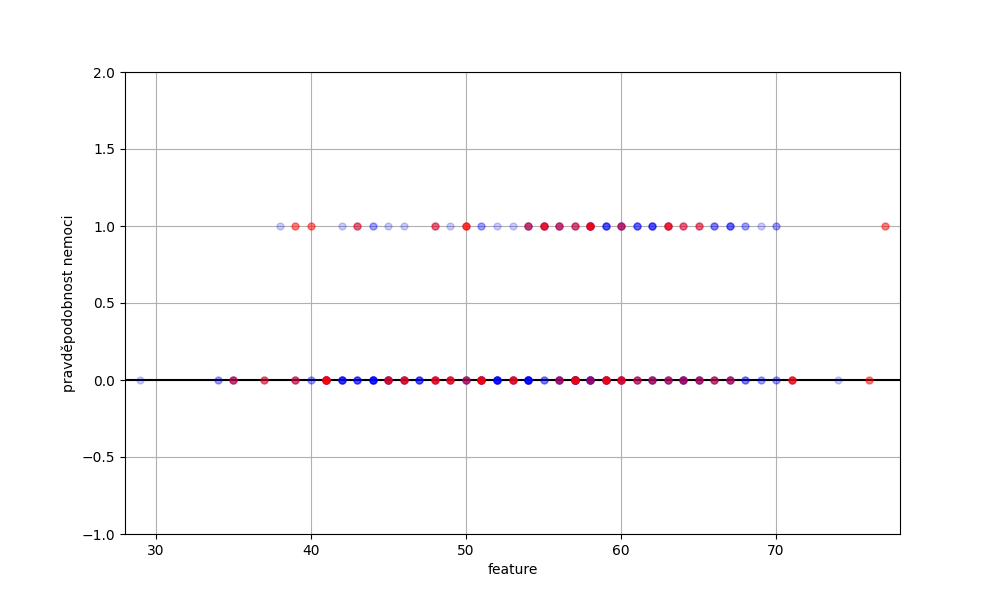

In [54]:
display_nonlinear_function_torch(g_dataframe_trn['age'],
                                 g_dataframe_val['age'],
                                 g_dataframe_trn['target'],
                                 g_dataframe_val['target'])

# Zkusme natrénovat model

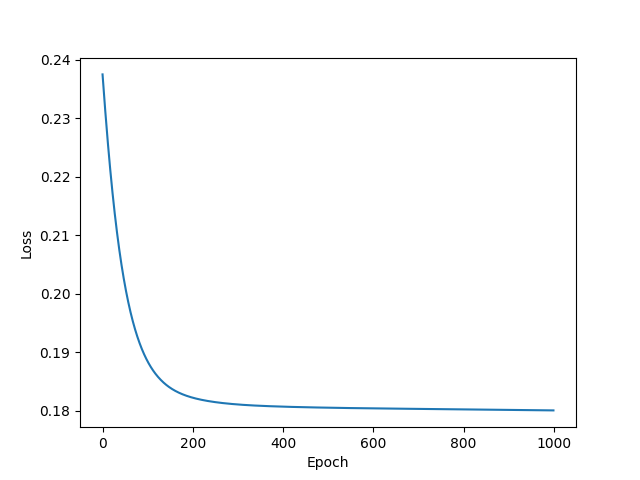

In [62]:
def train_one_feature(model, dataframe):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    loss_function = torch.nn.MSELoss()

    inputs = torch.Tensor(dataframe['age'].values).unsqueeze(1)
    labels = torch.Tensor(dataframe['target'].values).unsqueeze(1)

    inputs_mean = inputs.mean().item()
    inputs_std = inputs.std().item()
    inputs = (inputs - inputs_mean) / inputs_std

    loss_history = []

    for t in range(1000):

        y_pred = model(inputs)

        loss = loss_function(y_pred, labels)
        loss_history.append(loss.item())

        print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item()))
        IPydisplay.clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_history

g_model_one_feature = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)

print(g_dataframe_trn['age'])

g_one_feature_loss_h = train_one_feature(g_model_one_feature, g_dataframe_trn)

# Vykreslíme průběh trénování
plt.close()
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(g_one_feature_loss_h)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

# Jak dobrý je takový model?
- Zkusme porovnat průměrnou chybu modelu s úplně náhodným hádáním výsledku:
- Podívejme se také na vizualizaci modelu - vypadá rozumně?

+-------------------+---------------------+--------------------+---------------------+--------------------+
|       Model       |    Training error   |  Training error %  |   Validation error  | Validation error % |
+-------------------+---------------------+--------------------+---------------------+--------------------+
| One feature model | 0.35986529383808374 | 35.986529383808374 | 0.40475027043311324 | 40.47502704331132  |
|    Random guess   |  0.4793388429752066 | 47.93388429752066  | 0.45901639344262296 | 45.90163934426229  |
+-------------------+---------------------+--------------------+---------------------+--------------------+


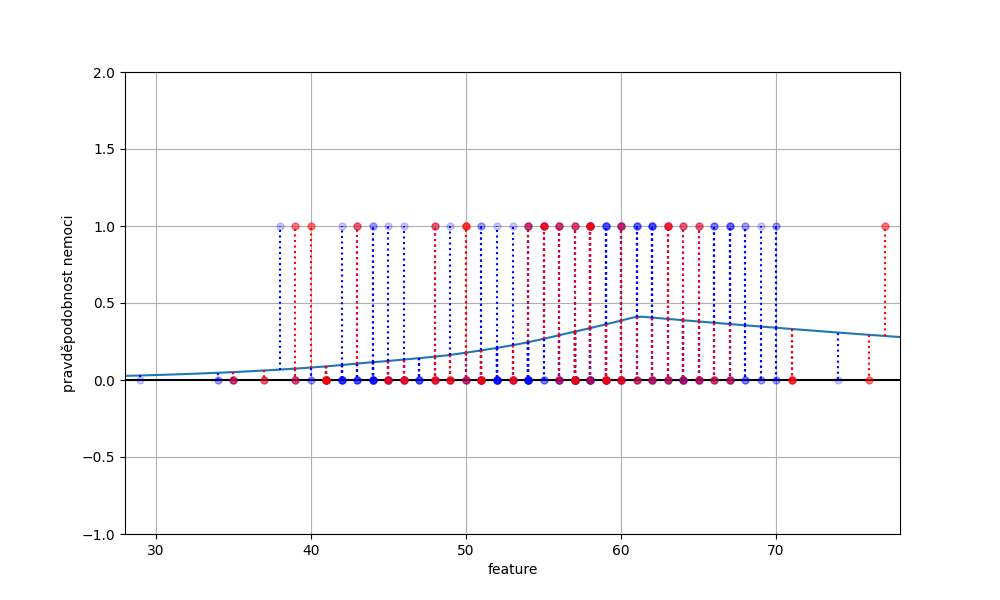

In [74]:
def one_feature_prediction(dataset, model):
    '''
    Funkce pro výpočet průměrné chyby predikce one feature modelu.
    '''
    inputs_mean = torch.Tensor(dataset['age'].values).mean().item()
    inputs_std = torch.Tensor(dataset['age'].values).std().item()

    error_value = 0
    largest_error = 0
    for i, row in dataset.iterrows():

        # normalizace
        input_tensor = (torch.Tensor([[row['age']]]) - inputs_mean) / inputs_std

        # predikce
        prediction = model(input_tensor).item()

        # chyba (absolutní rozdíl)
        error_value += abs(prediction - row['target'])

    return error_value / len(dataset)

def random_guess_error(dataset, normalize=False):
    '''
    Funkce pro výpočet při náhodném uhodnutí.
    '''
    error_value = 0
    for row in dataset.iloc:

        # Náhodně vybereme 0 nebo 1
        guess = np.random.randint(0, 2)
        # Chyba náhodného uhodnutí
        error_value += abs(guess - row['target'])
    return error_value / len(dataset)

# Spočítáme chybu na trénovacím setu
g_one_feature_err_trn = one_feature_prediction(g_dataframe_trn, g_model_one_feature)

# Spočítáme chybu na validačním setu
g_one_feature_err_val = one_feature_prediction(g_dataframe_val, g_model_one_feature)

# Spočítáme chybu náhodného hádání
g_random_err_trn = random_guess_error(dataset=g_dataframe_trn)
g_random_err_val = random_guess_error(dataset=g_dataframe_val)


# Uložíme si spočítané chyby do slovníku
g_model_errors = {"One feature model" : [g_one_feature_err_trn,
                                 g_one_feature_err_val],
                   "Random guess" : [g_random_err_trn,
                                     g_random_err_val]}

print_error_table(g_model_errors)

# Vykreslíme, co jsme to natrénovali
display_nonlinear_function_torch(g_dataframe_trn['age'],
                                 g_dataframe_val['age'],
                                 g_dataframe_trn['target'],
                                 g_dataframe_val['target'],
                                 g_model_one_feature)


# Potřebujeme další data...
- Model předpovídající nemoc jen z věku je velmi nepřesný (duh)
- Potřebujeme lépe rozlišit mladé lidi s nemocí a bez
- Zkusíme si přidat další feature - typ bolesti
    - Jak jsou na tom mladí lidé s bolestí typu 0-3?

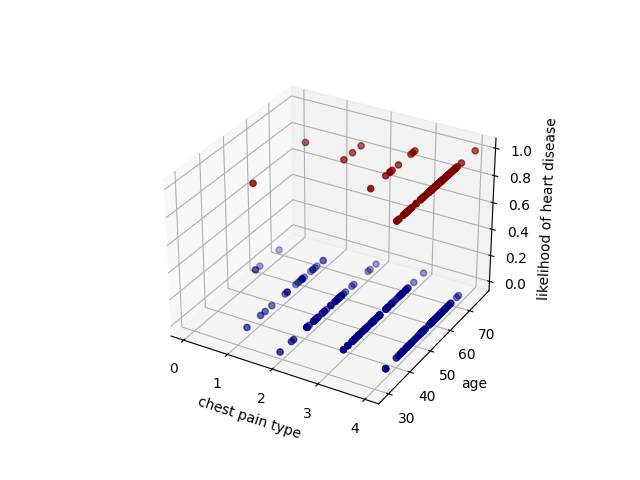

In [ ]:
# Přidáme další proměnnou a zobrazíme si 3d graf

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(dataframe['cp'], dataframe['age'], dataframe['target'], cmap='jet', c=dataframe['target'])

# osy x a y jsou proměnné, které máme k dispozici
ax.set_xlabel('chest pain type')
ax.set_ylabel('age')

# osa z je proměnná, kterou chceme predikovat
ax.set_zlabel('likelihood of heart disease')

plt.show()

# Zkusíme natrénovat model na dvou featurách
- Použijeme tentokrát knihovnu pytorch lightning https://lightning.ai/docs/pytorch/stable/
- Data si rozdělíme na trénovací a validační
    - Na trénovacích datech se model učí
    - Na validačních datech ověříme chování modelu pro data, která "nikdy neviděl"
- Musíme definovat model jako LightningModule
    - Vytvoříme si třídu LModel.
    - Třída je objekt, který má vlastní data (třeba self.model) a vlastní metody (třeba forward())
- AgePainDataset bude další třída. Obsahuje:
    - náš dataset,
    - metody pro zakódování a normalizaci dat,
    - metody pro vybírání vzorků z datasetu. (Vzorek je typu Tensor.)


In [ ]:
# Tady si nachystáme požadované třídy


# Vytvoříme model, tentokrát jako lightening module
class LModel(L.LightningModule):
    def __init__(self, inputs, hidden_units):
        super().__init__()

        # Samotný model je klasický sekvenční torch model
        self.model = torch.nn.Sequential(
            torch.nn.Linear(inputs, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, 1),
            torch.nn.Sigmoid()
        )

        self.trn_loss_history = []
        self.val_loss_history = []

    def forward(self, x):
        '''
        Funkce pro předání dat do modelu. Zde pouhé zavolání model, jak už jsme viděli dříve...
        '''
        return self.model(x)

    def configure_optimizers(self):
        '''
        Nastavení trénovacího algoritmu je tentokrát zde v modulu.
        '''
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        '''
        Funkce pro jeden trénovací krok.
        '''
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
        self.log("[TRAIN LOSS]", loss, prog_bar=True)
        self.trn_loss_history.append(loss.item())
        error = torch.mean(torch.abs(y_hat - y))
        self.log("[TRAIN ERROR]", error, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        '''
        Funkce pro jeden validační krok.
        '''
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
        self.val_loss_history.append(loss.item())
        error = torch.mean(torch.abs(y_hat - y))
        self.log("[VAL LOSS]", loss, prog_bar=True)
        self.log("[VAL ERROR]", error, prog_bar=True)
        return loss

# Torch Dataset pro naše dvě featury
class AgePainDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

        self.age_std = self.dataframe['age'].std()
        self.age_mean = self.dataframe['age'].mean()

    def __len__(self):
        return len(self.dataframe)

    def normalize_age(self, age):
        '''
        Číselnou featuru opět znormalizujeme aby se pohybovala kolem 0.
        '''
        return torch.tensor((age - self.age_mean) / self.age_std).unsqueeze(0).to(torch.float32)

    def one_hot_encode_cp(self, cp):
        '''
        Kategorickou featuru převedeme na one hot encoding.

        cp = 0 bude reprezentováno jako [1, 0, 0, 0, 0]
        cp = 1 bude reprezentováno jako [0, 1, 0, 0, 0]
        cp = 2 bude reprezentováno jako [0, 0, 1, 0, 0]
        ...
        '''
        one_hot = [0]*len(g_data_info["cp"]["encoding"])
        one_hot[cp] = 1
        return torch.tensor(one_hot).to(torch.float32)

    def __getitem__(self, idx):
        '''
        Funkce pro získání jednoho vzorku z datasetu.
        '''
        age = self.normalize_age(self.dataframe.iloc[idx]['age'])
        cp = self.dataframe.iloc[idx]['cp']
        cp = self.one_hot_encode_cp(cp)
        target = self.dataframe.iloc[idx]['target']
        return torch.cat((age, cp)), torch.tensor(target).unsqueeze(0).to(torch.float32)






# Trénovací smyčku teď zajistí "Trenér"
- Předtím jsme museli napsat smyčku sami, teď využijeme Trainer třídu z knihovny lightning

In [ ]:

# Z datasetu budeme vybírat podmnožiny dat s počtem vzorků batch_size
batch_size = 128

# 1 epocha = model "viděl" všechna data v datasetu. Počet epoch znamená kolikrát model "viděl" celý dataset.
epochs = 30

# Vytvoření modelu z naší třídy LModel
age_pain_model = LModel(inputs=6, hidden_units=32)

# Vytvoření "trenéra" z knihovny lightning
age_pain_trainer = L.Trainer(max_epochs=epochs)

# Data rozdělíme na dvě množiny
# Trénovací dataset - tyto data model uvidí během trénování
age_pain_dataset_train = AgePainDataset(dataframe.sample(frac=0.8, random_state=1))

# Validační dataset - tyto data model během trénování neuvidí. Změříme na nich, jak dobře se modelu daří predikovat pro vzorky, které nikdy neviděl.
age_pain_dataset_val = AgePainDataset(dataframe.drop(age_pain_dataset_train.dataframe.index))

print(f"Training dataset size: {len(age_pain_dataset_train)}")
print(f"Validation dataset size: {len(age_pain_dataset_val)}")

# Pomocné třídy na opakované vytahování batchů dat
train_dataloader = torch.utils.data.DataLoader(age_pain_dataset_train, batch_size=batch_size, drop_last=False, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(age_pain_dataset_val, batch_size=61, drop_last=False)

# Zde se teď skrývá trénovací smyčka
age_pain_trainer.fit(model=age_pain_model,
                    train_dataloaders=train_dataloader,
                    val_dataloaders=val_dataloader)

#age_pain_trainer.validate(model=age_pain_model, dataloaders=val_dataloader)



INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 257    | train
---------------------------------------------
257       Trainable params
0         Non-trainable params
257       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 257    | train
---------------------------------------------
257       Trainable params
0         No

Training dataset size: 242
Validation dataset size: 61


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Text(0, 0.5, 'Loss')

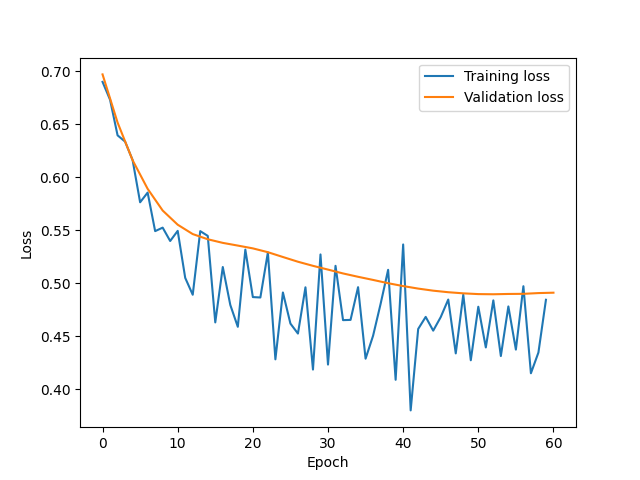

In [ ]:
# Vykreslíme historii trénovacícho lossu
loss_history = age_pain_model.trn_loss_history
val_loss_history = age_pain_model.val_loss_history
val_x_axis_indices = np.linspace(0, len(loss_history), len(val_loss_history)).astype(int)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(loss_history, label='Training loss')
ax.plot(val_x_axis_indices, val_loss_history, label='Validation loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')



# Vizualizujeme si natrénovaný model
- Model odpovídá nějaké funkci - vykreslíme si ji

Two features model prediction error: 0.30792023838427, model is 30.792023838427003 % wrong on average. Largest error is 97.32113070786 %
One feature model prediction error: 0.37818338478555774, model is 37.81833847855577 % wrong on average. Largest error is 87.96002194285393 %
Random guess error: 0.45544554455445546, model is 45.54455445544555 % wrong on average. Largest error is 100 %


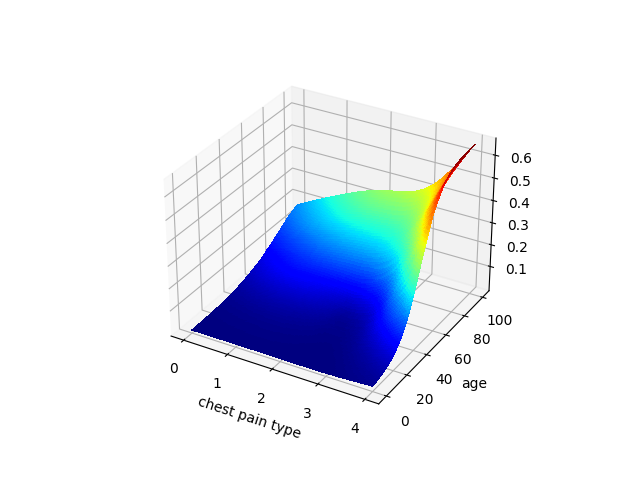

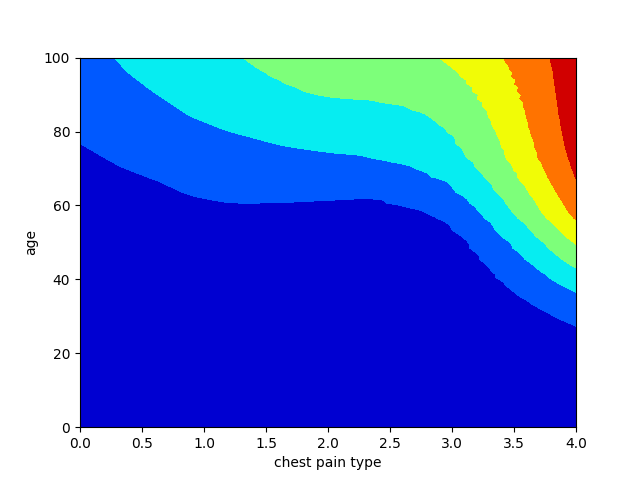

In [ ]:
# Jaká je průměrná chyba predikce modelu na celém datasetu?

def mean_dataset_error_two_feature(dataset, model):
    '''
    Funkce pro výpočet hodnoty chybové funkce L1 pro lineární regresi na celém datasetu.
    '''
    error_value = 0
    largest_error = 0
    for row in dataset.iloc:
        input_tensor = torch.cat((age_pain_dataset_train.normalize_age(row['age']), age_pain_dataset_train.one_hot_encode_cp(row['cp'])))
        prediction = model(input_tensor)
        row_error = abs(prediction.item() - row['target'])
        if row_error > largest_error:
            largest_error = row_error
        error_value += row_error
    return error_value / len(dataset), largest_error

def display_two_feature_function(model_arg):
    # Nachystáme si rozsah možných hodnot pro věk a cp
    grid_age = np.arange(0, 110, 1)
    grid_cp = np.arange(0, 5, 1)

    # pustíme předikce pro všechny kombinace věků a cp a sledujeme průběh predikce pomocí tqdm
    possible_ages = []
    possible_cps = []
    predictions = []

    for age in grid_age:
        for cp in grid_cp:
            possible_ages.append(age)
            possible_cps.append(cp)
            input_age = age_pain_dataset_train.normalize_age(age)
            input_cp = age_pain_dataset_train.one_hot_encode_cp(cp)
            input_data = torch.cat((input_age, input_cp))
            predictions.append(model_arg(input_data).item())

    # Vykreslíme si predikce
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    from scipy.interpolate import griddata
    # připravíme si mřížku bodů pro vykreslení
    grid_x, grid_y = np.mgrid[0:4:100j, 0:100:100j]
    grid_z = griddata((possible_cps, possible_ages), predictions, (grid_x, grid_y), method='cubic', fill_value=0)

    ax.plot_surface(grid_x, grid_y, grid_z, cmap='jet',rstride=1, cstride=1,
                          linewidth=0, antialiased=False, shade=False)
    ax.set_xlabel('chest pain type')
    ax.set_ylabel('age')
    plt.show()

    fig = plt.figure()
    ax2d = fig.add_subplot()
    ax2d.contourf(grid_x, grid_y, grid_z, cmap='jet')
    ax2d.set_xlabel('chest pain type')
    ax2d.set_ylabel('age')
    plt.show()

g_two_feature_err, g_two_feature_lerr = mean_dataset_error_two_feature(dataframe, age_pain_model)

print(f"Two features model prediction error: {g_two_feature_err}, model is {g_two_feature_err*100} % wrong on average. Largest error is {g_two_feature_lerr*100} %")

print(f"One feature model prediction error: {g_one_feature_err}, model is {g_one_feature_err*100} % wrong on average. Largest error is {g_one_feature_lerr*100} %")

print(f"Random guess error: {g_random_err}, model is {g_random_err*100} % wrong on average. Largest error is {g_random_lerr*100} %")

display_two_feature_function(model_arg=age_pain_model)
